Can the mean temperature in Dehli be predicted using time series analysis? In this project, I will attempt to predict the daily mean temperature in Dehli, India. This might be useful for various applications, such as weather forecast and sales of items that have a high correlation with temperature changes, such as potable water, ice, umbrellas, rain coats, sunblock, fans, etc.

In [115]:
import pandas as pd
#!pip install pmdarima
import pmdarima as pm
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels as ss
#!pip install prophet

In [116]:
df = pd.read_csv('datasets/DailyDelhiClimateTrain.csv')
df_temp = df[['date', 'meantemp']]
nan_count=df_temp.isna().sum()
print(nan_count)

date        0
meantemp    0
dtype: int64


There aren't any nan values in date or meantemp

In [117]:
# Use panda's describe to have a big picture feel for the data

df_temp['meantemp'].describe()

count    1462.000000
mean       25.495521
std         7.348103
min         6.000000
25%        18.857143
50%        27.714286
75%        31.305804
max        38.714286
Name: meantemp, dtype: float64

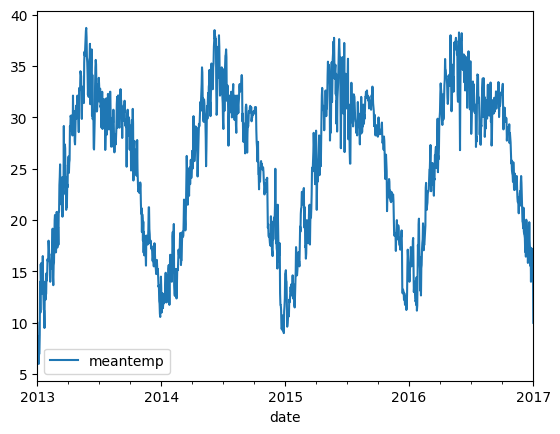

In [118]:
df_temp.set_index('date', inplace=True)
df_temp.index = pd.to_datetime(df_temp.index)
df_temp.plot()
plt.savefig('runsequence_plot.png', dpi=300)

There is seasonality and autocorrelation, and at first glance there doesn't seem to be a significant trend. The seasonality seems to be additive rather than multiplicative.

In [119]:
# Generate a complete date range from the start to the end of the dataset
full_date_range = pd.date_range(start=df_temp.index.min(), end=df_temp.index.max(), freq='D')

# Reindex the DataFrame to the full date range
df_temp_reindexed = df_temp.reindex(full_date_range)

# Check for missing dates
missing_dates = df_temp_reindexed[df_temp_reindexed['meantemp'].isna()].index

print(f"Missing dates: {missing_dates}")

# Output the missing dates
if not missing_dates.empty:
    print(f"Missing dates: {missing_dates.tolist()}")
else:
    print("There are no missing dates in the dataset.")

print(f'Number of samples: {df_temp.shape[0]}')

Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='D')
There are no missing dates in the dataset.
Number of samples: 1462


In [120]:
# split data into 17 chunks
chunks = np.split(df_temp, indices_or_sections=17)

mean_vals = np.mean(chunks,axis=1)
var_vals = np.var(chunks,axis=1)
print(f'mean values: \n{mean_vals}')
print(f'variance values: \n{var_vals}')

mean values: 
[[17.01710963]
 [31.2160299 ]
 [30.51236157]
 [22.94777132]
 [14.72923588]
 [27.65780731]
 [32.85724328]
 [26.69186047]
 [14.73255814]
 [25.07163621]
 [31.95639535]
 [29.4072363 ]
 [17.12135244]
 [23.90435316]
 [34.11385683]
 [31.10675687]
 [22.38028649]]
variance values: 
[[26.20400883]
 [14.15996868]
 [ 3.31767426]
 [23.76357923]
 [ 4.88850635]
 [17.89324914]
 [ 6.25186215]
 [16.5247181 ]
 [11.98555393]
 [25.86674993]
 [ 8.55582289]
 [ 5.43532273]
 [13.08345712]
 [35.23468142]
 [ 5.54298241]
 [ 2.86705786]
 [22.0330908 ]]


There doesn't seem to be an exaggerated difference in the variation between the different chunks, this indicates an aproximately constant variance.

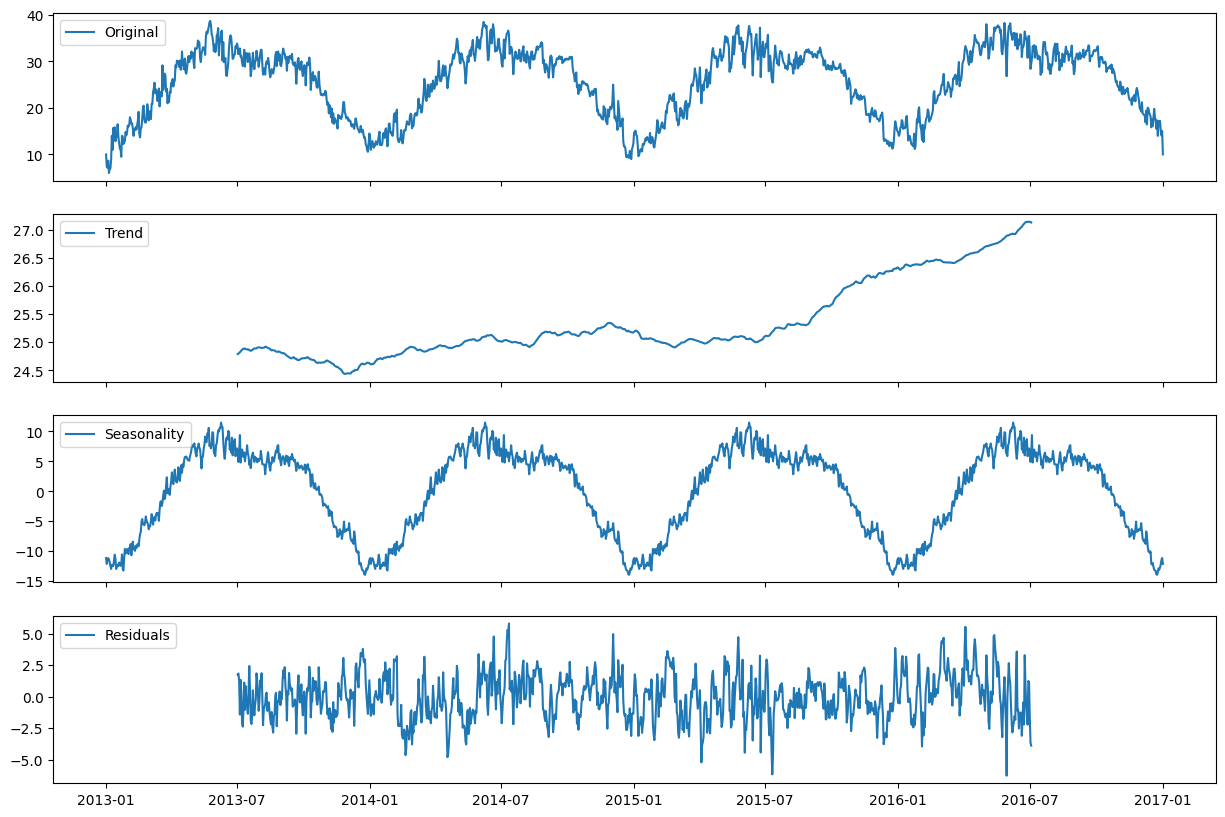

In [121]:
# Next, I will decompose in trend, seasonality and residuals

from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=df_temp, model='additive', period=365)

estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(df_temp, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

plt.savefig('decomposition_before.png', dpi=300)

By doing a decomposition, I can tell that there is infact an ascending trend in the temperature. The seasonal component looks that it oscillates well without significantly changing in time, and the residuals look pretty stationary.

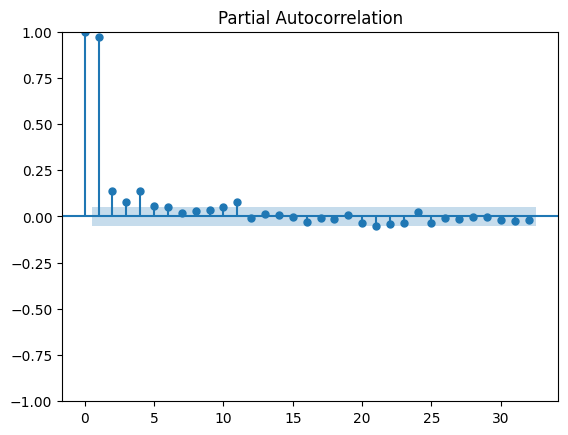

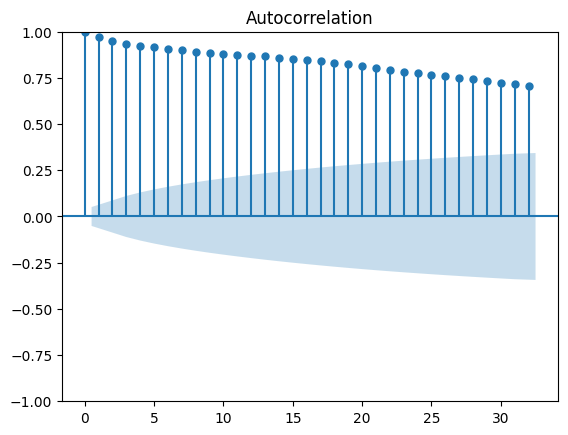

In [122]:
# Now I want to obtain the ACF and PCF plots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_temp)
plt.savefig('pacf_before.png', dpi=300)
plt.show()

plot_acf(df_temp)
plt.savefig('acf_before.png', dpi=300)
plt.show()

The autocorrelation is slowly decaying, while the partial autocorrelation shows 4 significant terms after the partial correlation of the first term with itself.

I will apply the adf test to verify stationarity.

In [123]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df_temp)

print(f'ADF test statistic value: {adf}')
print(f'P-value: {pvalue}')
print(f'Critical values: {critical_values}')


ADF test statistic value: -2.0210690559206737
P-value: 0.2774121372301601
Critical values: {'1%': -3.4348647527922824, '5%': -2.863533960720434, '10%': -2.567831568508802}


The p-value is too large, the series is not stationary. I will apply differencing to counter the trend.

In [124]:
temp_diff = df_temp['meantemp'].diff().dropna()

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(temp_diff)

print(f'ADF test statistic value: {adf}')
print(f'P-value: {pvalue}')
print(f'Critical values: {critical_values}')

ADF test statistic value: -16.378720267074684
P-value: 2.764863137594565e-29
Critical values: {'1%': -3.4348647527922824, '5%': -2.863533960720434, '10%': -2.567831568508802}


After differencing one time, the data is stationary. Now I will plot the pcf and pacf tests for the differenced data.

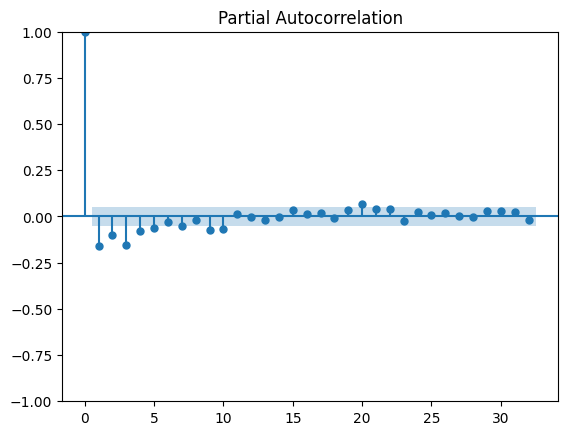

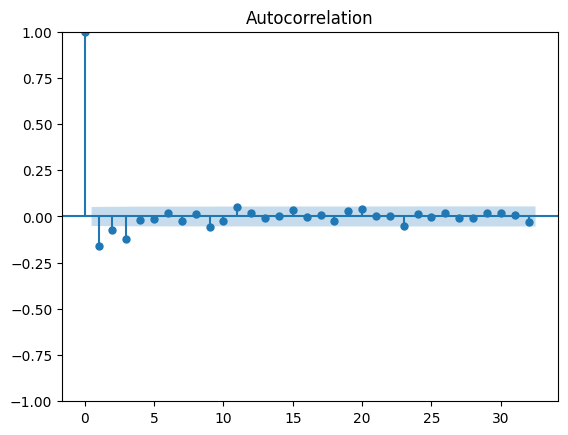

In [125]:
plot_pacf(temp_diff)
plt.savefig('pacf_after.png', dpi=300)
plt.show()

plot_acf(temp_diff)
plt.savefig('acf_after.png', dpi=300)
plt.show()

There appear to be 4 significant lags in the pcf plot, which means an AR(p=4) model and 3 significant lags in the pacf plot, which means an MA(q=3). I will use a SARIMA model with these parameters.

In [126]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_temp['meantemp'], order=(4, 1, 3))
model_fit = model.fit()

# Step 6: Print the summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1462
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -2749.903
Date:                Fri, 17 May 2024   AIC                           5515.806
Time:                        00:38:39   BIC                           5558.101
Sample:                    01-01-2013   HQIC                          5531.583
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7032      0.033     21.339      0.000       0.639       0.768
ar.L2          0.9968      0.039     25.456      0.000       0.920       1.074
ar.L3         -0.6914      0.028    -24.629      0.0

Now I will use this model to do predictions and compare with the test dataset via mse and rmse.

Mean Squared Error: 269.14885924580835 C^2
Root Mean Squared Error: 16.405756893414225 C


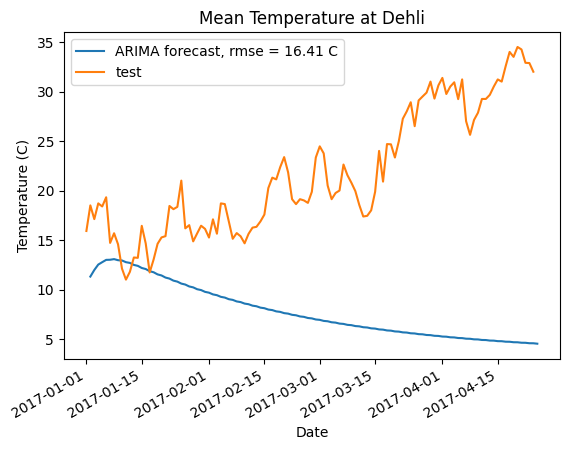

In [127]:
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates

# Read the test data set
df_test = pd.read_csv('datasets/DailyDelhiClimateTest.csv')
df_temp_test = df_test[['date', 'meantemp']]
df_temp_test.set_index('date', inplace=True)
df_temp_test.index = pd.to_datetime(df_temp_test.index)

# Make predictions
df_forecast1 = pd.DataFrame()
df_forecast1['meantemp'] = model_fit.predict(start=len(df_temp), end=len(df_temp)+len(df_temp_test)-1, dynamic=True)

# Calculate mse and rmse
mse_1 = mean_squared_error(df_temp_test['meantemp'], df_forecast1['meantemp'])
rmse_1 = np.sqrt(mse_1)
print(f"Mean Squared Error: {mse_1} C^2")
print(f"Root Mean Squared Error: {rmse_1} C")

plt.plot(df_forecast1.index, df_forecast1['meantemp'], label=f'ARIMA forecast, rmse = {np.around(rmse_1, 2)} C')
plt.plot(df_temp_test.index, df_temp_test['meantemp'], label='test')
plt.title('Mean Temperature at Dehli')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend()
# Setting date format for x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# Rotating the date labels for better readability
plt.gcf().autofmt_xdate()
plt.savefig('arima_forecast.png', dpi=300)
plt.show()

In [128]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")


# seasonal=False assumes no seasonality. Adjust seasonal=True for seasonal data
model2 = auto_arima(df_temp['meantemp'], 
                   seasonal=False, 
                   trace=True, 
                   error_action='ignore', 
                   suppress_warnings=True, 
                   stepwise=True)

# Step 5: Print the model summary
print(model2.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5546.314, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5650.181, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5614.068, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5602.114, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5648.181, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5546.168, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5573.723, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5544.460, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5546.100, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5600.849, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5542.478, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5600.115, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5612.068, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5544.118, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]          

Mean Squared Error: 113.40936948344283 C^2
Root Mean Squared Error: 10.649383525981344 C


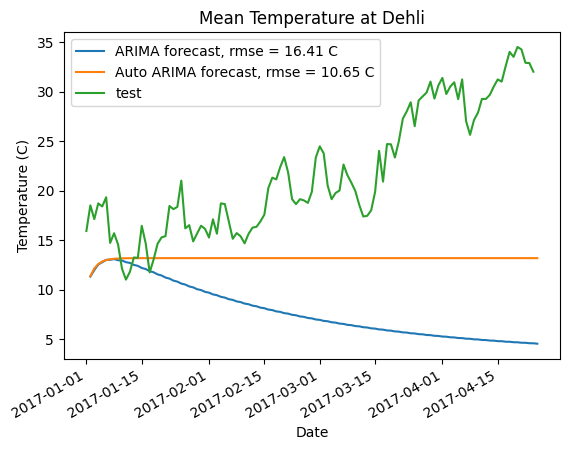

In [134]:
n_periods = 115
forecast, conf_int = model2.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df_temp_test.index[0], periods=n_periods, freq='D')
df_forecast2 = pd.DataFrame(forecast, index=index_of_fc, columns=['meantemp'])

df_forecast2.dropna(inplace=True)


# Calculate mse and rmse
mse_2 = mean_squared_error(df_temp_test, df_forecast2)
rmse_2 = np.sqrt(mse_2)
print(f"Mean Squared Error: {mse_2} C^2")
print(f"Root Mean Squared Error: {rmse_2} C")

plt.plot(df_forecast1.index, df_forecast1['meantemp'], label=f'ARIMA forecast, rmse = {np.around(rmse_1, 2)} C')
plt.plot(df_forecast2.index, df_forecast2['meantemp'], label=f'Auto ARIMA forecast, rmse = {np.around(rmse_2, 2)} C')
plt.plot(df_temp_test.index, df_temp_test['meantemp'], label='test')
#plt.fill_between(df_temp_test.index, 
#                 conf_int[:, 0], 
#                 conf_int[:, 1], 
#                 color='k', alpha=.15)
plt.title('Mean Temperature at Dehli')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend()
# Setting date format for x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# Rotating the date labels for better readability
plt.gcf().autofmt_xdate()
plt.savefig('auto_arima_forecast.png', dpi=300)
plt.show()


00:42:40 - cmdstanpy - INFO - Chain [1] start processing
00:42:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 7.20390964957685 C^2
Root Mean Squared Error: 2.6840099943138904 C


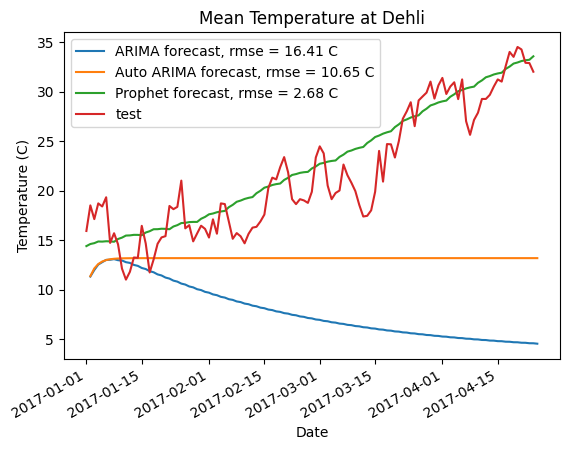

In [135]:
from prophet import Prophet

model3 = Prophet()
# Extract 'meantemp' column and set the index as 'ds'
df_temp_prophet = df_temp[['meantemp']].copy()
df_temp_prophet['ds'] = df_temp.index

# Rename the column 'meantemp' as 'y'
df_temp_prophet.rename(columns={'meantemp': 'y'}, inplace=True)

model3.fit(df_temp_prophet)

future3 = model3.make_future_dataframe(periods=len(df_temp_test)-1)
forecast3 = model3.predict(future3)

# Extract the predicted values for the test set
forecast3 = forecast3[forecast3['ds'].isin(df_temp_test.index)]

# Calculate MSE and RMSE
mse_3 = mean_squared_error(df_temp_test['meantemp'], forecast3['yhat'])
rmse_3 = np.sqrt(mse3)
print(f"Mean Squared Error: {mse_3} C^2")
print(f"Root Mean Squared Error: {rmse_3} C")

plt.plot(df_forecast1.index, df_forecast1['meantemp'], label=f'ARIMA forecast, rmse = {np.around(rmse_1, 2)} C')
plt.plot(df_forecast2.index, df_forecast2['meantemp'], label=f'Auto ARIMA forecast, rmse = {np.around(rmse_2, 2)} C')
plt.plot(forecast3['ds'], forecast3['yhat'], label=f'Prophet forecast, rmse = {np.around(rmse_3, 2)} C')
plt.plot(df_temp_test.index, df_temp_test['meantemp'], label='test')
#plt.fill_between(df_temp_test.index, 
#                 conf_int[:, 0], 
#                 conf_int[:, 1], 
#                 color='k', alpha=.15)
plt.title('Mean Temperature at Dehli')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend()
# Setting date format for x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# Rotating the date labels for better readability
plt.gcf().autofmt_xdate()
plt.savefig('prophet_forecast.png', dpi=300)
plt.show()

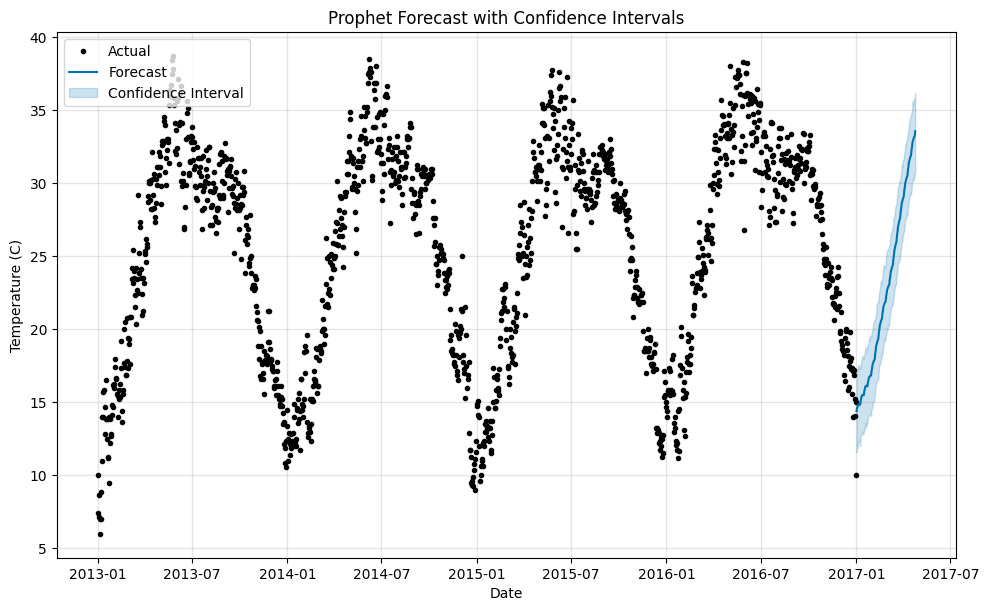

In [87]:
# Plotting the forecast along with confidence intervals
fig = model3.plot(forecast3)
plt.title('Prophet Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend(['Actual', 'Forecast', 'Confidence Interval'], loc='upper left')
plt.show()


In [139]:
df_temp_test.index.min()

Timestamp('2017-01-01 00:00:00')